In [1]:
from datetime import datetime, timezone, timedelta
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from helpers import util
import os

In [2]:
today = datetime.now(timezone.utc).replace(tzinfo=None)
today

datetime.datetime(2025, 11, 16, 11, 40, 7, 418435)

In [3]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
sensors_str = secrets.get_secret("SENSORS_JSON").value
sensors_data = json.loads(sensors_str)

2025-11-16 12:40:07,425 INFO: Initializing external client
2025-11-16 12:40:07,426 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 12:40:07,913 WARNING: UserWarning: The installed hopsworks client version 4.1.4 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 12:40:08,818 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272018


In [4]:
mr = project.get_model_registry()

retrieved_model_base = mr.get_model(
    name="air_quality_xgboost_base_model",
    version=1,
)
retrieved_model_lagged = mr.get_model(
    name="air_quality_xgboost_lagged_model",
    version=1,
)

# Download the saved models artifacts to a local directory
saved_model_dir_base = retrieved_model_base.download()
saved_model_dir_lagged = retrieved_model_lagged.download()

In [5]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model_base = XGBRegressor()
retrieved_xgboost_model_base.load_model(saved_model_dir_base + "/model.json")
retrieved_xgboost_model_lagged = XGBRegressor()
retrieved_xgboost_model_lagged.load_model(saved_model_dir_lagged + "/model.json")

In [6]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

yesterday_2359 = (today - timedelta(days=1)).replace(hour=23, minute=59, second=59, microsecond=0)
air_quality_data = air_quality_fg.filter(air_quality_fg.date >= yesterday_2359.date()).read().drop(columns="url")
weather_data = weather_fg.filter(weather_fg.date >= today).read().sort_values(by='date')

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.54s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.78s) 


In [7]:
weather_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-17 00:00:00+00:00,0.65,0.0,10.805998,330.018433,årjäng
1,2025-11-17 00:00:00+00:00,-0.45,0.0,10.464797,333.435028,jonsbyn
5,2025-11-17 00:00:00+00:00,0.45,0.0,10.883676,325.784241,skoghall
7,2025-11-17 00:00:00+00:00,-0.20,0.0,9.504273,335.376465,nykroppa
2,2025-11-18 00:00:00+00:00,0.50,0.0,1.484318,284.036255,skoghall
3,2025-11-18 00:00:00+00:00,0.35,0.0,2.968636,345.963715,jonsbyn
4,2025-11-18 00:00:00+00:00,0.55,0.0,1.440000,270.000000,nykroppa
6,2025-11-18 00:00:00+00:00,0.40,0.0,3.096837,35.537766,årjäng
10,2025-11-19 00:00:00+00:00,-1.50,0.0,5.400000,36.869980,skoghall
11,2025-11-19 00:00:00+00:00,-0.55,0.0,3.075841,69.443871,nykroppa


In [8]:
air_quality_data

,date,pm25,lagged_1,lagged_2,lagged_3,country,city,street
0,2025-11-16 00:00:00+00:00,4.0,7.0,2.0,2.0,sweden,nykroppa,timmersvägen
1,2025-11-16 00:00:00+00:00,11.0,5.0,3.0,2.0,sweden,skoghall,folkungavägen
2,2025-11-16 00:00:00+00:00,2.0,2.0,2.0,0.0,sweden,årjäng,strand
3,2025-11-16 00:00:00+00:00,3.0,2.0,1.0,1.0,sweden,jonsbyn,acksjön


In [9]:
def prepare_prediction_row(row, air_quality_data, lagged_available):
    # Ensure air_quality_data['date'] is datetime
    air_quality_data['date'] = pd.to_datetime(air_quality_data['date'])
    
    # Initialize dictionary for features
    features = {}
    city = row['city']
    pred_date = pd.to_datetime(row['date'])
    prev_date = pred_date - pd.Timedelta(days=1)

    # filter the air quality data
    last_days_aq = air_quality_data[
        (air_quality_data['city'] == city) &
        (air_quality_data['date'].dt.date == prev_date.date())
    ]

    if lagged_available:
        features['lagged_3'] = last_days_aq['lagged_2'].item()
        features['lagged_2'] = last_days_aq['lagged_1'].item()
        features['lagged_1'] = last_days_aq['predicted_pm25'].item()
    features['city'] = city
    features['street'] = last_days_aq['street'].item()
    features['country'] = last_days_aq['country'].item()
    features['date'] = pred_date
    
    # Copy weather features
    weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
    for col in weather_cols:
        features[col] = row[col]
    
    # Convert to single-row DataFrame
    prediction_df = pd.DataFrame([features])
    prediction_df['city'] = prediction_df['city'].astype('category')
    
    return prediction_df

In [10]:
def append_predicted_pm25(air_quality_data, prediction_row, predicted_pm25, lagged_available):
    new_row = prediction_row
    new_row["predicted_pm25"] = predicted_pm25
    if lagged_available:
        new_row['lagged_1'] = prediction_row['lagged_1']
        new_row['lagged_2'] = prediction_row['lagged_2']
        new_row['lagged_3'] = prediction_row['lagged_3']
    
    # Append new row to DataFrame
    updated_air_quality_data = pd.concat([air_quality_data, pd.DataFrame(new_row)], ignore_index=True)
    return updated_air_quality_data

In [11]:
air_quality_forecast_base = air_quality_data.copy().drop(columns=['lagged_1', 'lagged_2', 'lagged_3']).rename(columns={"pm25": "predicted_pm25"})
air_quality_forecast_lagged = air_quality_data.copy().rename(columns={"pm25": "predicted_pm25"})

for _, prediction in weather_data.iterrows():
    pred_date = pd.to_datetime(prediction['date'])
    prediction_df_base = prepare_prediction_row(prediction, air_quality_forecast_base, lagged_available=False)
    prediction_df_lagged = prepare_prediction_row(prediction, air_quality_forecast_lagged, lagged_available=True)
    predicted_pm25_base = retrieved_xgboost_model_base.predict(prediction_df_base[['city', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    predicted_pm25_lagged = retrieved_xgboost_model_lagged.predict(prediction_df_lagged[['lagged_1', 'lagged_2', 'lagged_3', 'city', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    air_quality_forecast_base = append_predicted_pm25(air_quality_forecast_base, prediction_df_base, predicted_pm25_base, lagged_available=False)
    air_quality_forecast_lagged = append_predicted_pm25(air_quality_forecast_lagged, prediction_df_lagged, predicted_pm25_lagged, lagged_available=True)

In [12]:
weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
air_quality_forecast_base[weather_cols] = air_quality_forecast_base[weather_cols].astype('float32')
air_quality_forecast_base["date"] = pd.to_datetime(air_quality_forecast_base["date"]).dt.tz_convert(None)
air_quality_forecast_base['days_before_forecast_day'] = (air_quality_forecast_base["date"] - pd.Timestamp(today).normalize()).dt.days
air_quality_forecast_base = air_quality_forecast_base[air_quality_forecast_base['days_before_forecast_day'] > 0]
air_quality_forecast_base

,date,predicted_pm25,country,city,street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,days_before_forecast_day
4,2025-11-17,7.771799,sweden,årjäng,strand,0.65,0.0,10.805998,330.018433,1
5,2025-11-17,6.198400,sweden,jonsbyn,acksjön,-0.45,0.0,10.464797,333.435028,1
6,2025-11-17,5.396018,sweden,skoghall,folkungavägen,0.45,0.0,10.883676,325.784241,1
7,2025-11-17,6.556006,sweden,nykroppa,timmersvägen,-0.20,0.0,9.504273,335.376465,1
8,2025-11-18,13.391301,sweden,skoghall,folkungavägen,0.50,0.0,1.484318,284.036255,2
9,2025-11-18,12.898911,sweden,jonsbyn,acksjön,0.35,0.0,2.968636,345.963715,2
10,2025-11-18,15.846894,sweden,nykroppa,timmersvägen,0.55,0.0,1.440000,270.000000,2
11,2025-11-18,19.400652,sweden,årjäng,strand,0.40,0.0,3.096837,35.537766,2
12,2025-11-19,20.701363,sweden,skoghall,folkungavägen,-1.50,0.0,5.400000,36.869980,3
13,2025-11-19,20.031595,sweden,nykroppa,timmersvägen,-0.55,0.0,3.075841,69.443871,3


In [13]:
weather_cols = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
air_quality_forecast_lagged[weather_cols] = air_quality_forecast_base[weather_cols].astype('float32')
air_quality_forecast_lagged["date"] = pd.to_datetime(air_quality_forecast_lagged["date"]).dt.tz_convert(None)
air_quality_forecast_lagged['days_before_forecast_day'] = (air_quality_forecast_lagged["date"] - pd.Timestamp(today).normalize()).dt.days
air_quality_forecast_lagged = air_quality_forecast_lagged[air_quality_forecast_lagged['days_before_forecast_day'] > 0]
air_quality_forecast_lagged

,date,predicted_pm25,lagged_1,lagged_2,lagged_3,country,city,street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,days_before_forecast_day
4,2025-11-17,5.492182,2.000000,2.000000,2.000000,sweden,årjäng,strand,0.65,0.0,10.805998,330.018433,1
5,2025-11-17,3.225350,3.000000,2.000000,1.000000,sweden,jonsbyn,acksjön,-0.45,0.0,10.464797,333.435028,1
6,2025-11-17,6.780057,11.000000,5.000000,3.000000,sweden,skoghall,folkungavägen,0.45,0.0,10.883676,325.784241,1
7,2025-11-17,4.793284,4.000000,7.000000,2.000000,sweden,nykroppa,timmersvägen,-0.20,0.0,9.504273,335.376465,1
8,2025-11-18,9.510566,6.780057,11.000000,5.000000,sweden,skoghall,folkungavägen,0.50,0.0,1.484318,284.036255,2
9,2025-11-18,5.369264,3.225350,3.000000,2.000000,sweden,jonsbyn,acksjön,0.35,0.0,2.968636,345.963715,2
10,2025-11-18,7.776848,4.793284,4.000000,7.000000,sweden,nykroppa,timmersvägen,0.55,0.0,1.440000,270.000000,2
11,2025-11-18,7.182092,5.492182,2.000000,2.000000,sweden,årjäng,strand,0.40,0.0,3.096837,35.537766,2
12,2025-11-19,12.231739,9.510566,6.780057,11.000000,sweden,skoghall,folkungavägen,-1.50,0.0,5.400000,36.869980,3
13,2025-11-19,13.493825,7.776848,4.793284,4.000000,sweden,nykroppa,timmersvägen,-0.55,0.0,3.075841,69.443871,3


In [14]:
# Creating a directory for the model artifacts if it doesn't exist
docs_folder = "docs"
if not os.path.exists(docs_folder):
    os.mkdir(docs_folder)
    
base_folder = docs_folder + "/air_quality"
if not os.path.exists(base_folder):
    os.mkdir(base_folder)
    
base_model_dir = base_folder + "/base"
if not os.path.exists(base_model_dir):
    os.mkdir(base_model_dir)
base_images_dir = base_model_dir + "/images"
if not os.path.exists(base_images_dir):
    os.mkdir(base_images_dir)

lagged_model_dir = base_folder + "/lagged"
if not os.path.exists(lagged_model_dir):
    os.mkdir(lagged_model_dir)
lagged_images_dir = lagged_model_dir + "/images"
if not os.path.exists(lagged_images_dir):
    os.mkdir(lagged_images_dir)

In [15]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")

2025-11-16 12:40:25,087 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



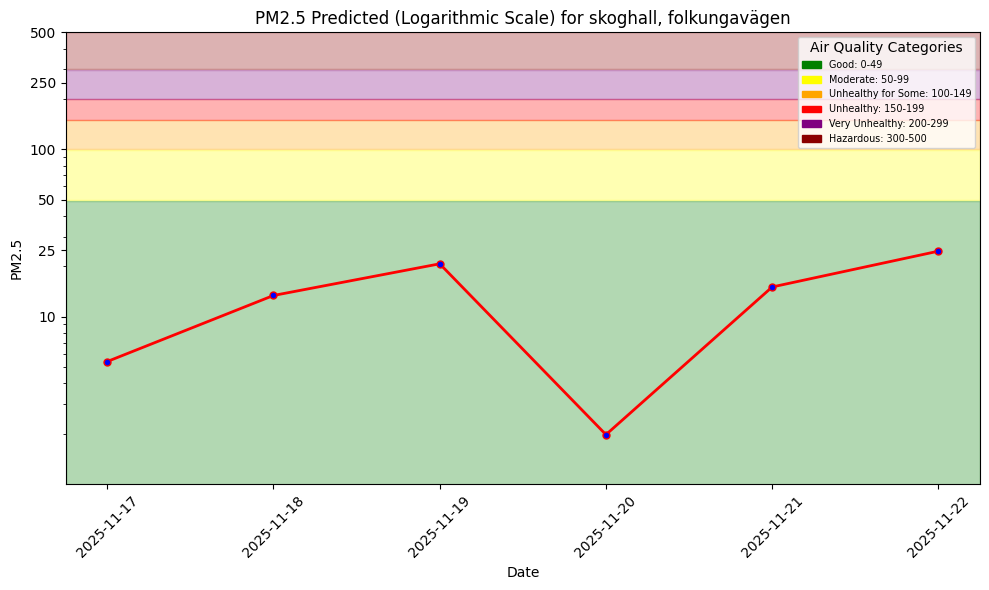

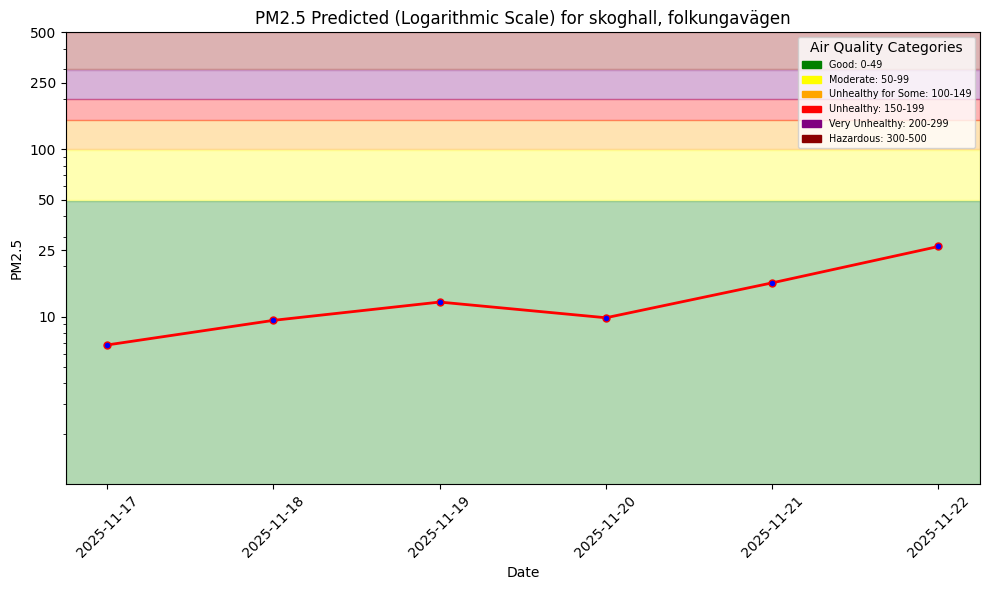

Uploading: 0.000%|          | 0/53010 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/46128 elapsed<00:00 remaining<?

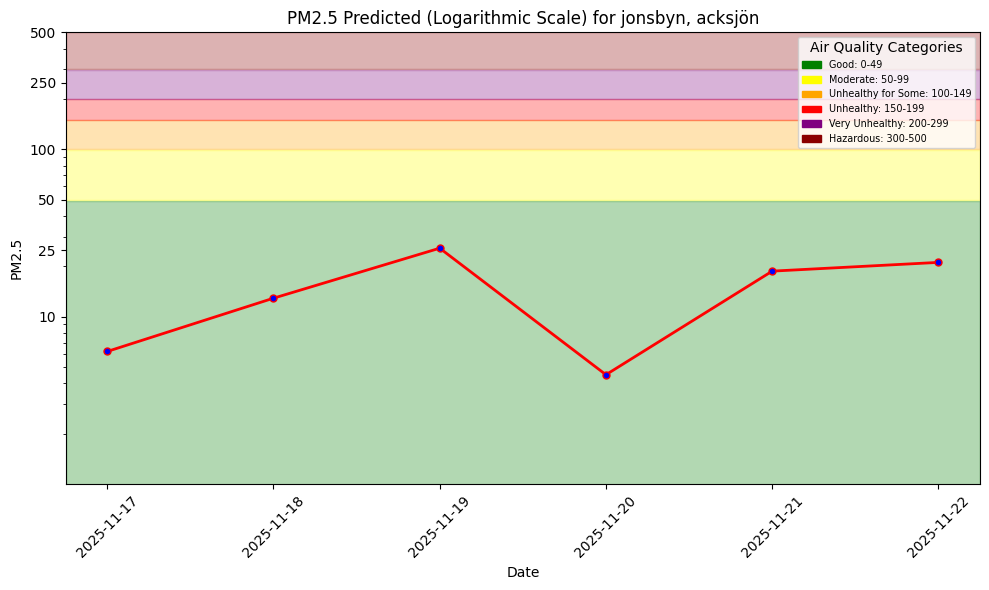

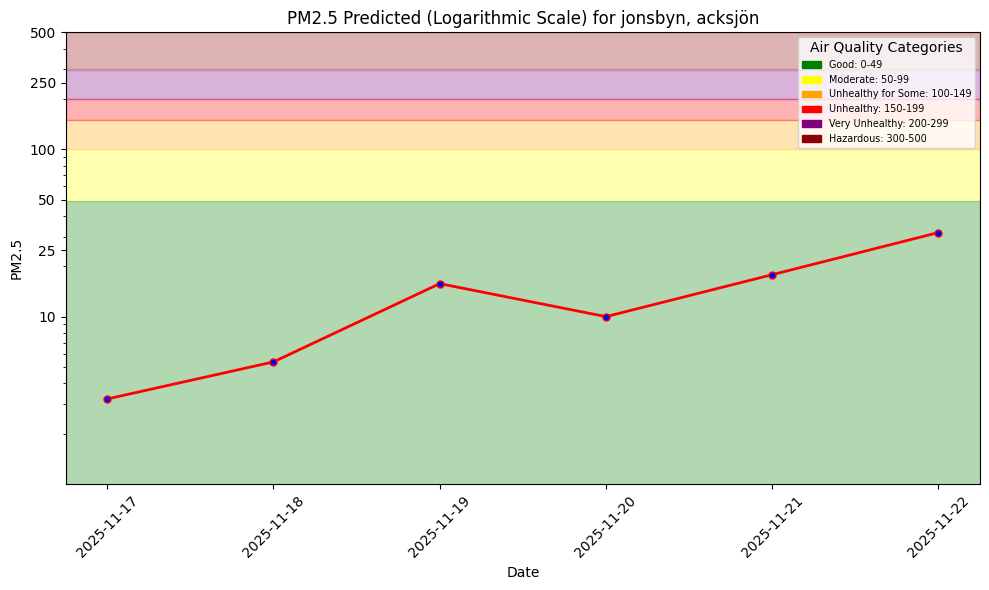

Uploading: 0.000%|          | 0/51066 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/48808 elapsed<00:00 remaining<?

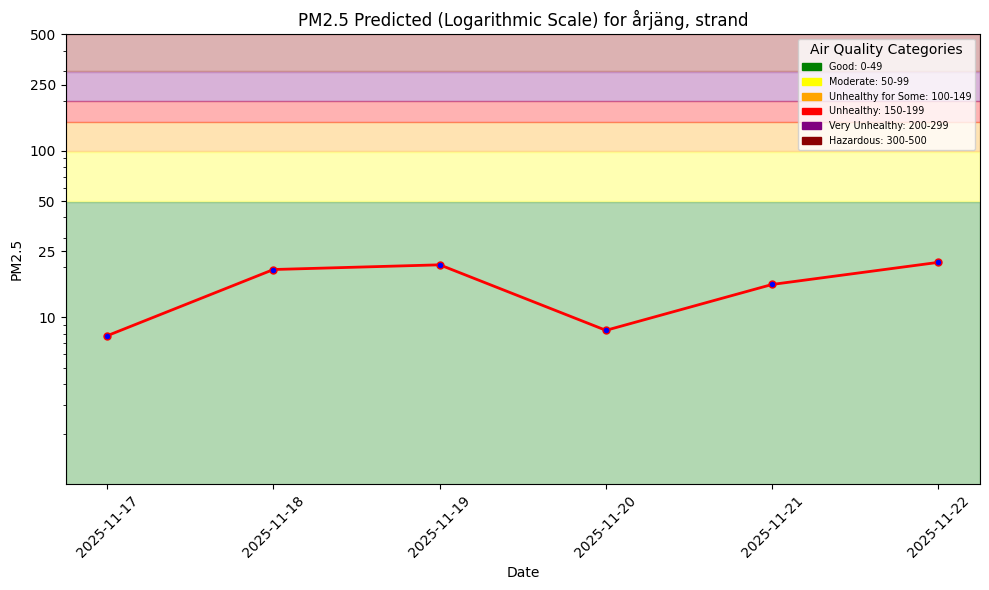

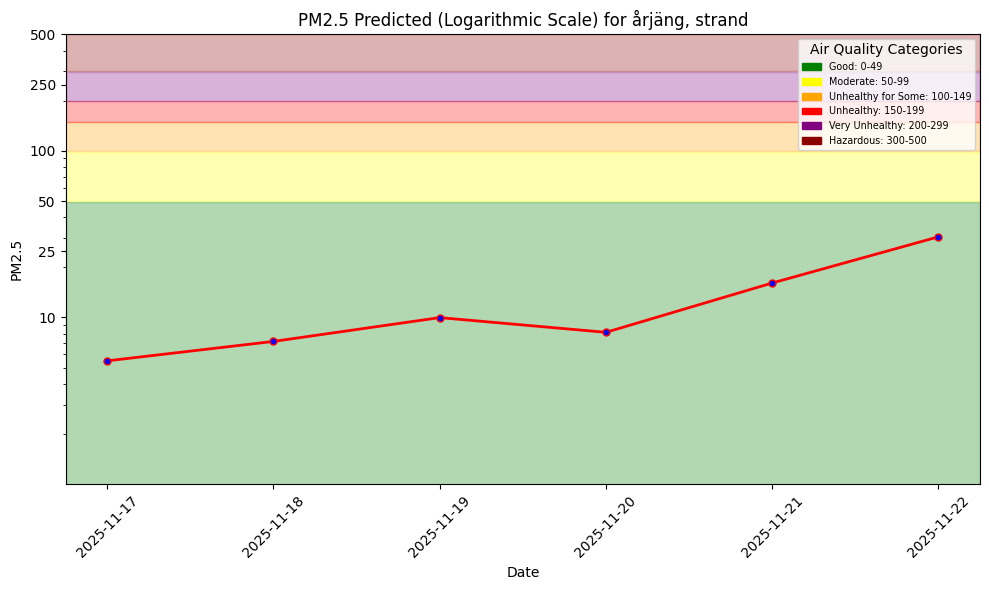

Uploading: 0.000%|          | 0/46782 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/45152 elapsed<00:00 remaining<?

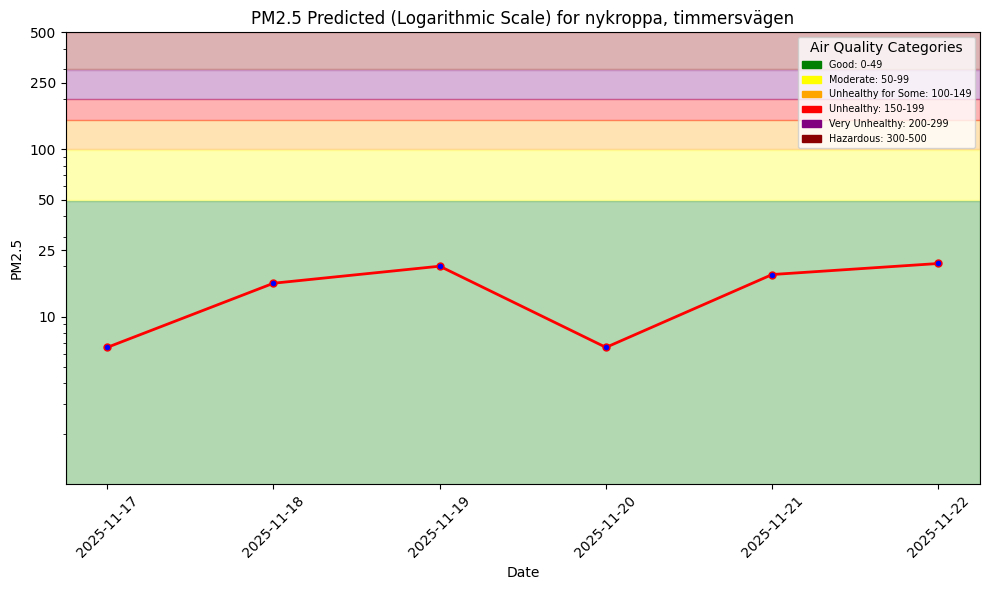

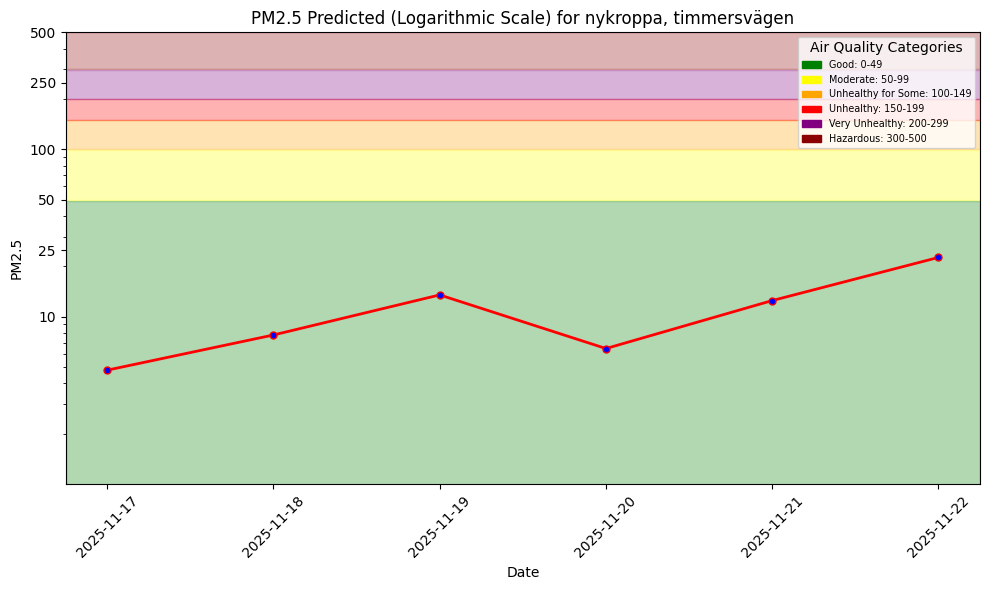

Uploading: 0.000%|          | 0/49614 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/49694 elapsed<00:00 remaining<?

In [16]:
for location in sensors_data:
    city = location['city']
    street = location['street']
    base_city_dir = f"{base_images_dir}/{city}"
    lagged_city_dir = f"{lagged_images_dir}/{city}"
    if not os.path.exists(base_city_dir):
        os.mkdir(base_city_dir)
    if not os.path.exists(lagged_city_dir):
        os.mkdir(lagged_city_dir)
    base_file_path = f"{base_city_dir}/pm25_forecast.png"
    lagged_file_path = f"{lagged_city_dir}/pm25_forecast.png"
    base_plt = util.plot_air_quality_forecast(city, street, air_quality_forecast_base[air_quality_forecast_base['city'] == city], base_file_path)
    lagged_plt = util.plot_air_quality_forecast(city, street, air_quality_forecast_lagged[air_quality_forecast_lagged['city'] == city], lagged_file_path)
    base_plt.show()
    lagged_plt.show()
    dataset_api.upload(base_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(lagged_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

In [17]:
monitor_fg_base = fs.get_or_create_feature_group(
    name='aq_predictions_base',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','country','days_before_forecast_day'],
    event_time="date"
)

monitor_fg_lagged = fs.get_or_create_feature_group(
    name='aq_predictions_lagged',
    description='Air Quality prediction monitoring (lagged)',
    version=1,
    primary_key=['city','street','country','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg_base.insert(air_quality_forecast_base)
monitor_fg_lagged.insert(air_quality_forecast_lagged, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 24/24 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_base_1_offline_fg_materialization


In [ ]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_base = monitor_fg_base.filter(monitor_fg_base.days_before_forecast_day == 1).read()
monitoring_lagged = monitor_fg_lagged.filter(monitor_fg_lagged.days_before_forecast_day == 1).read()

air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()

In [ ]:
preds_base =  monitoring_base[['date', 'predicted_pm25', 'city']]
preds_lagged =  monitoring_lagged[['date', 'predicted_pm25', 'city']]

hindcast_base = pd.merge(preds_base, air_quality_df, on=["date", "city"])
hindcast_base = hindcast_base.sort_values(by=['date'])

hindcast_lagged = pd.merge(preds_lagged, air_quality_df, on=["date", "city"])
hindcast_lagged = hindcast_lagged.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
for location in sensors_data:
    city = location['city']
    street = location['street']
    hindcast_location_base = hindcast_base[hindcast_base['city'] == city]
    hindcast_location_lagged = hindcast_lagged[hindcast_lagged['city'] == city]
    base_city_dir = f"{base_images_dir}/{city}"
    lagged_city_dir = f"{lagged_images_dir}/{city}" 
    base_hindcast_path = f"{base_city_dir}/pm25_hindcast.png"
    lagged_hindcast_path = f"{lagged_city_dir}/pm25_hindcast.png"
    base_plt = util.plot_air_quality_forecast(city, street, hindcast_location_base, base_hindcast_path, hindcast=True)
    lagged_plt = util.plot_air_quality_forecast(city, street, hindcast_location_lagged, lagged_hindcast_path, hindcast=True)
    base_plt.show()
    lagged_plt.show()
    dataset_api.upload(base_hindcast_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(lagged_hindcast_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")